# Correcting Misclassified Images Using Combined CNN with Tsetlin Machine

In [1]:
# Install required packages
!pip install tensorflow matplotlib numpy tmu scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from tmu.models.classification.vanilla_classifier import TMClassifier
from sklearn.model_selection import train_test_split

2025-03-30 11:37:33,911 - tmu.util.cuda_profiler - WARNING - Could not import pycuda: No module named 'pycuda'
2025-03-30 11:37:33,913 - tmu.clause_bank.clause_bank_cuda - ERROR - No module named 'pycuda'
Traceback (most recent call last):
  File "c:\Users\ahpuh\AppData\Local\Programs\Python\Python310\lib\site-packages\tmu\clause_bank\clause_bank_cuda.py", line 41, in <module>
    from pycuda._driver import Device, Context
ModuleNotFoundError: No module named 'pycuda'
2025-03-30 11:37:33,914 - tmu.clause_bank.clause_bank_cuda - WARNING - Could not import pycuda. This indicates that it is not installed! A possible fix is to run 'pip install pycuda'. Fallback to CPU ClauseBanks.


## 1. Load and Prepare CIFAR-10 Dataset

In [3]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Print dataset sizes
print(f"Training set: {len(x_train)} images")
print(f"Test set: {len(x_test)} images")
print(f"Total dataset: {len(x_train) + len(x_test)} images")
print(f"Split ratio (train:test): {len(x_train) / len(x_test):.1f}:1")
print(f"Training percentage: {len(x_train) / (len(x_train) + len(x_test)) * 100:.1f}%")
print(f"Test percentage: {len(x_test) / (len(x_train) + len(x_test)) * 100:.1f}%")

x_train, x_test = x_train / 255.0, x_test / 255.0
y_train_cat, y_test_cat = to_categorical(y_train, 10), to_categorical(y_test, 10)

Training set: 50000 images
Test set: 10000 images
Total dataset: 60000 images
Split ratio (train:test): 5.0:1
Training percentage: 83.3%
Test percentage: 16.7%


## 2. Build and Train a Simple CNN

In [4]:
# Create a model that only goes up to the feature layer
def build_feature_extractor():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),  # Input layer
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu')  # Feature layer
    ])
    return model

# Create a full CNN model for classification
def build_classifier():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),  # Input layer
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),  # Feature layer
        layers.Dense(10, activation='softmax')  # Classification layer
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train the full CNN classifier
cnn_model = build_classifier()
cnn_model.fit(x_train, y_train_cat, epochs=5, batch_size=64, validation_data=(x_test, y_test_cat))

# Build the feature extractor with identical layers up to the feature layer
feature_extractor = build_feature_extractor()

# Copy weights from trained classifier to feature extractor
for i in range(len(feature_extractor.layers)):
    feature_extractor.layers[i].set_weights(cnn_model.layers[i].get_weights())



Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.3675 - loss: 1.7530 - val_accuracy: 0.5213 - val_loss: 1.3309
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5537 - loss: 1.2780 - val_accuracy: 0.5437 - val_loss: 1.2918
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5921 - loss: 1.1606 - val_accuracy: 0.5946 - val_loss: 1.1530
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6199 - loss: 1.0831 - val_accuracy: 0.5922 - val_loss: 1.1726
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6437 - loss: 1.0325 - val_accuracy: 0.5854 - val_loss: 1.1530


Extracting features...
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Creating improved binary features...
x_train_tm shape: (50000, 192), dtype: uint32
y_train_tm shape: (50000,), dtype: uint32
Training Tsetlin Machine Ensemble...

Training Ensemble Member 1/3
Config: {'clauses': 150, 'T': 10, 's': 3.0}
Epoch	Train Accuracy	Val Accuracy
----------------------------------------
 1/30	0.6051		0.5676
 6/30	0.6150		0.5766
11/30	0.6163		0.5761
16/30	0.6169		0.5784
21/30	0.6171		0.5814
26/30	0.6186		0.5756
30/30	0.6172		0.5775


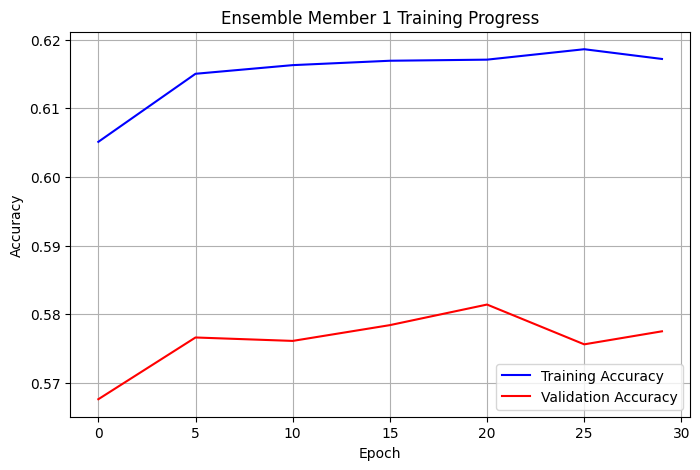


Training Ensemble Member 2/3
Config: {'clauses': 200, 'T': 15, 's': 5.0}
Epoch	Train Accuracy	Val Accuracy
----------------------------------------
 1/30	0.6231		0.5805
 6/30	0.6347		0.5846
11/30	0.6379		0.5863
16/30	0.6406		0.5850
21/30	0.6389		0.5836
26/30	0.6401		0.5862
30/30	0.6410		0.5830


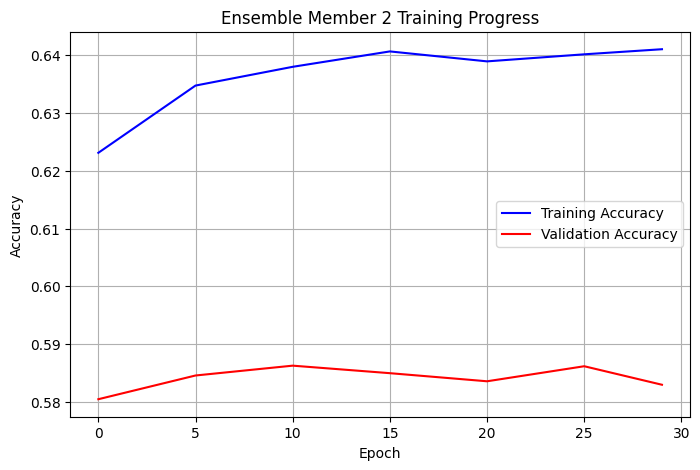


Training Ensemble Member 3/3
Config: {'clauses': 250, 'T': 20, 's': 7.0}
Epoch	Train Accuracy	Val Accuracy
----------------------------------------
 1/30	0.6342		0.5866
 6/30	0.6458		0.5946
11/30	0.6481		0.6013
16/30	0.6504		0.5973
21/30	0.6539		0.5988
26/30	0.6528		0.5990
30/30	0.6538		0.5997


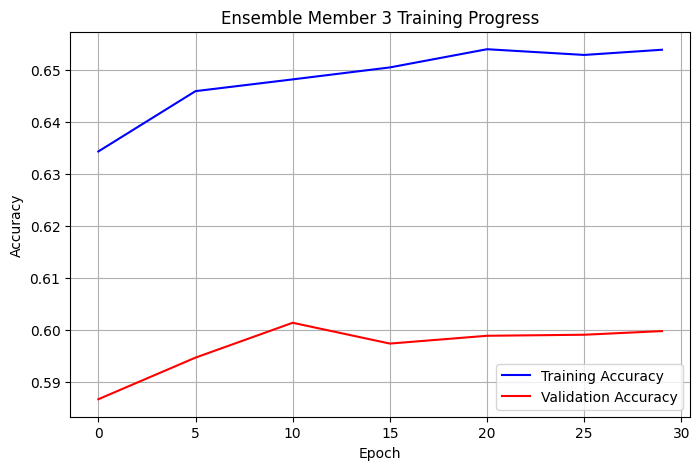


Evaluating ensemble...
Ensemble Test Accuracy: 0.5919

Comparison:
Member 1 accuracy: 0.5775
Member 2 accuracy: 0.5830
Member 3 accuracy: 0.5997
Ensemble accuracy: 0.5919
Error during training: name 'confusion_matrix' is not defined

Data information:
x_train_tm min: 0, max: 1
y_train_tm values: [0 1 2 3 4 5 6 7 8 9]

Trying simplified version...
Simplified TM accuracy: 0.5268


<Figure size 800x600 with 0 Axes>

In [6]:
def improved_binarization(features, num_thresholds=3):
    """Convert features to binary using multiple thresholds for better information retention"""
    # Get feature dimensions
    n_samples, n_features = features.shape
    
    # Create binary feature array with increased size to hold multiple thresholds per feature
    binary_features = np.zeros((n_samples, n_features * num_thresholds), dtype=np.uint32)
    
    for feat_idx in range(n_features):
        # Calculate percentile-based thresholds for this feature
        feat_values = features[:, feat_idx]
        percentiles = np.linspace(25, 75, num_thresholds)
        thresholds = np.percentile(feat_values, percentiles)
        
        # Apply each threshold to create binary features
        for t_idx, threshold in enumerate(thresholds):
            binary_idx = feat_idx * num_thresholds + t_idx
            binary_features[:, binary_idx] = (feat_values > threshold).astype(np.uint32)
    
    return binary_features

# After extracting features with the feature_extractor
print("Extracting features...")
x_train_features = feature_extractor.predict(x_train)
x_test_features = feature_extractor.predict(x_test)

# Create enhanced binary features with multiple thresholds
print("Creating improved binary features...")
x_train_tm = improved_binarization(x_train_features, num_thresholds=3)
x_test_tm = improved_binarization(x_test_features, num_thresholds=3)

# Convert labels to uint32 as required by TMU
y_train_tm = np.argmax(y_train_cat, axis=1).astype(np.uint32)
y_test_tm = np.argmax(y_test_cat, axis=1).astype(np.uint32)

# Print shapes and dtypes to verify
print(f"x_train_tm shape: {x_train_tm.shape}, dtype: {x_train_tm.dtype}")
print(f"y_train_tm shape: {y_train_tm.shape}, dtype: {y_train_tm.dtype}")

# Create an ensemble of Tsetlin Machines with different configurations
from tmu.models.classification.vanilla_classifier import TMClassifier

# Define hyperparameter variations for ensemble members
ensemble_configs = [
    {'clauses': 150, 'T': 10, 's': 3.0},
    {'clauses': 200, 'T': 15, 's': 5.0},
    {'clauses': 250, 'T': 20, 's': 7.0}
]

# Create and train ensemble members
print("Training Tsetlin Machine Ensemble...")
ensemble_members = []
num_epochs = 30
ensemble_val_accuracies = []

try:
    for i, config in enumerate(ensemble_configs):
        print(f"\nTraining Ensemble Member {i+1}/{len(ensemble_configs)}")
        print(f"Config: {config}")
        
        # Create TM with this configuration
        tm = TMClassifier(
            number_of_clauses=config['clauses'],
            T=config['T'],
            s=config['s'],
            boost_true_positive_feedback=1,
            weighted_clauses=False
        )
        
        # Train with progress tracking
        member_train_acc = []
        member_val_acc = []
        
        print("Epoch\tTrain Accuracy\tVal Accuracy")
        print("-" * 40)
        
        for epoch in range(num_epochs):
            # Train for one epoch
            tm.fit(x_train_tm, y_train_tm, epochs=1)
            
            # Calculate metrics every 5 epochs to speed up training
            if epoch % 5 == 0 or epoch == num_epochs - 1:
                train_pred = tm.predict(x_train_tm)
                train_acc = accuracy_score(y_train_tm, train_pred)
                member_train_acc.append(train_acc)
                
                val_pred = tm.predict(x_test_tm)
                val_acc = accuracy_score(y_test_tm, val_pred)
                member_val_acc.append(val_acc)
                
                print(f"{epoch+1:2d}/{num_epochs}\t{train_acc:.4f}\t\t{val_acc:.4f}")
        
        # Add to ensemble
        ensemble_members.append(tm)
        ensemble_val_accuracies.append(val_acc)
        
        # Plot training progress for this member
        plt.figure(figsize=(8, 5))
        epochs_plotted = [e for e in range(num_epochs) if e % 5 == 0 or e == num_epochs - 1]
        plt.plot(epochs_plotted, member_train_acc, 'b-', label='Training Accuracy')
        plt.plot(epochs_plotted, member_val_acc, 'r-', label='Validation Accuracy')
        plt.title(f'Ensemble Member {i+1} Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # Make ensemble predictions (majority voting)
    print("\nEvaluating ensemble...")
    ensemble_predictions = []
    for i in range(len(x_test_tm)):
        sample = x_test_tm[i:i+1]
        votes = [tm.predict(sample)[0] for tm in ensemble_members]
        # Get most frequent prediction (mode)
        ensemble_pred = max(set(votes), key=votes.count)
        ensemble_predictions.append(ensemble_pred)
    
    # Calculate ensemble accuracy
    ensemble_accuracy = accuracy_score(y_test_tm, ensemble_predictions)
    print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}")
    
    # Compare with individual members
    print("\nComparison:")
    for i, tm in enumerate(ensemble_members):
        member_acc = ensemble_val_accuracies[i]
        print(f"Member {i+1} accuracy: {member_acc:.4f}")
    print(f"Ensemble accuracy: {ensemble_accuracy:.4f}")
    
    # Confusion matrix for ensemble
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test_tm, ensemble_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Ensemble Confusion Matrix')
    plt.show()
    
except Exception as e:
    print(f"Error during training: {str(e)}")
    
    # Debug information
    print(f"\nData information:")
    print(f"x_train_tm min: {x_train_tm.min()}, max: {x_train_tm.max()}")
    print(f"y_train_tm values: {np.unique(y_train_tm)}")
    
    # Try simplified version if needed
    print("\nTrying simplified version...")
    try:
        # Use simple binary features
        x_train_simple = (x_train_features > np.mean(x_train_features, axis=0)).astype(np.uint32)
        x_test_simple = (x_test_features > np.mean(x_train_features, axis=0)).astype(np.uint32)
        
        # Train a single TM with conservative settings
        simple_tm = TMClassifier(number_of_clauses=100, T=10, s=3.0)
        simple_tm.fit(x_train_simple, y_train_tm, epochs=10)
        
        # Evaluate
        simple_acc = accuracy_score(y_test_tm, simple_tm.predict(x_test_simple))
        print(f"Simplified TM accuracy: {simple_acc:.4f}")
        
    except Exception as e2:
        print(f"Simplified version failed: {str(e2)}")

In the context of your CNN+Tsetlin combined model, the threshold refers to the confidence level below which predictions from the CNN are considered unreliable and are replaced by predictions from the Tsetlin Machine.

How the Threshold Works:

1.Confidence Measurement: When the CNN makes a prediction, it outputs probability scores for each class. The highest probability is considered the model's confidence in its prediction.

2.Decision Rule:

If confidence ≥ threshold: Use the CNN's prediction

If confidence < threshold: Use the Tsetlin Machine's prediction instead

3.Threshold Selection: The optimal threshold value is typically determined empirically by testing different values (e.g., 0.5, 0.6, 0.7, 0.8, 0.9) and selecting the one that yields the best performance.

Impact of Different Threshold Values:

1.Lower threshold (e.g., 0.5):

More conservative approach

Only very low-confidence CNN predictions will be replaced

Fewer samples will be passed to the Tsetlin Machine

The combined model will behave more like the CNN alone

2.Higher threshold (e.g., 0.9):

More aggressive approach

Even moderate-confidence CNN predictions will be replaced


More samples will be passed to the Tsetlin Machine

The combined model will rely more heavily on the Tsetlin Machine


Setting the right threshold is a balancing act - you want to replace inaccurate CNN predictions while keeping accurate ones. The optimal threshold depends on:

The relative strengths of each model

The dataset characteristics

The distribution of the CNN's confidence scores

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN Test Accuracy: 0.5854
Tsetlin Machine Ensemble Test Accuracy: 0.5919
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Threshold 0.5: Combined Accuracy = 0.5876, TM Usage = 38.3%
  → TM accuracy on low confidence subset: 0.3804
  → Net improvement from using TM: 22 samples
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Threshold 0.6: Combined Accuracy = 0.5874, TM Usage = 53.6%
  → TM accuracy on low confidence subset: 0.4189
  → Net improvement from using TM: 20 samples
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Threshold 0.7: Combined Accuracy = 0.5865, TM Usage = 65.5%
  → TM accuracy on low confidence subset: 0.4528
  → Net improvement from using TM: 11 samples
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Threshold 0.8: Combined Accuracy = 0.5883, TM Usage = 75.5%
  → TM accuracy on low confidence

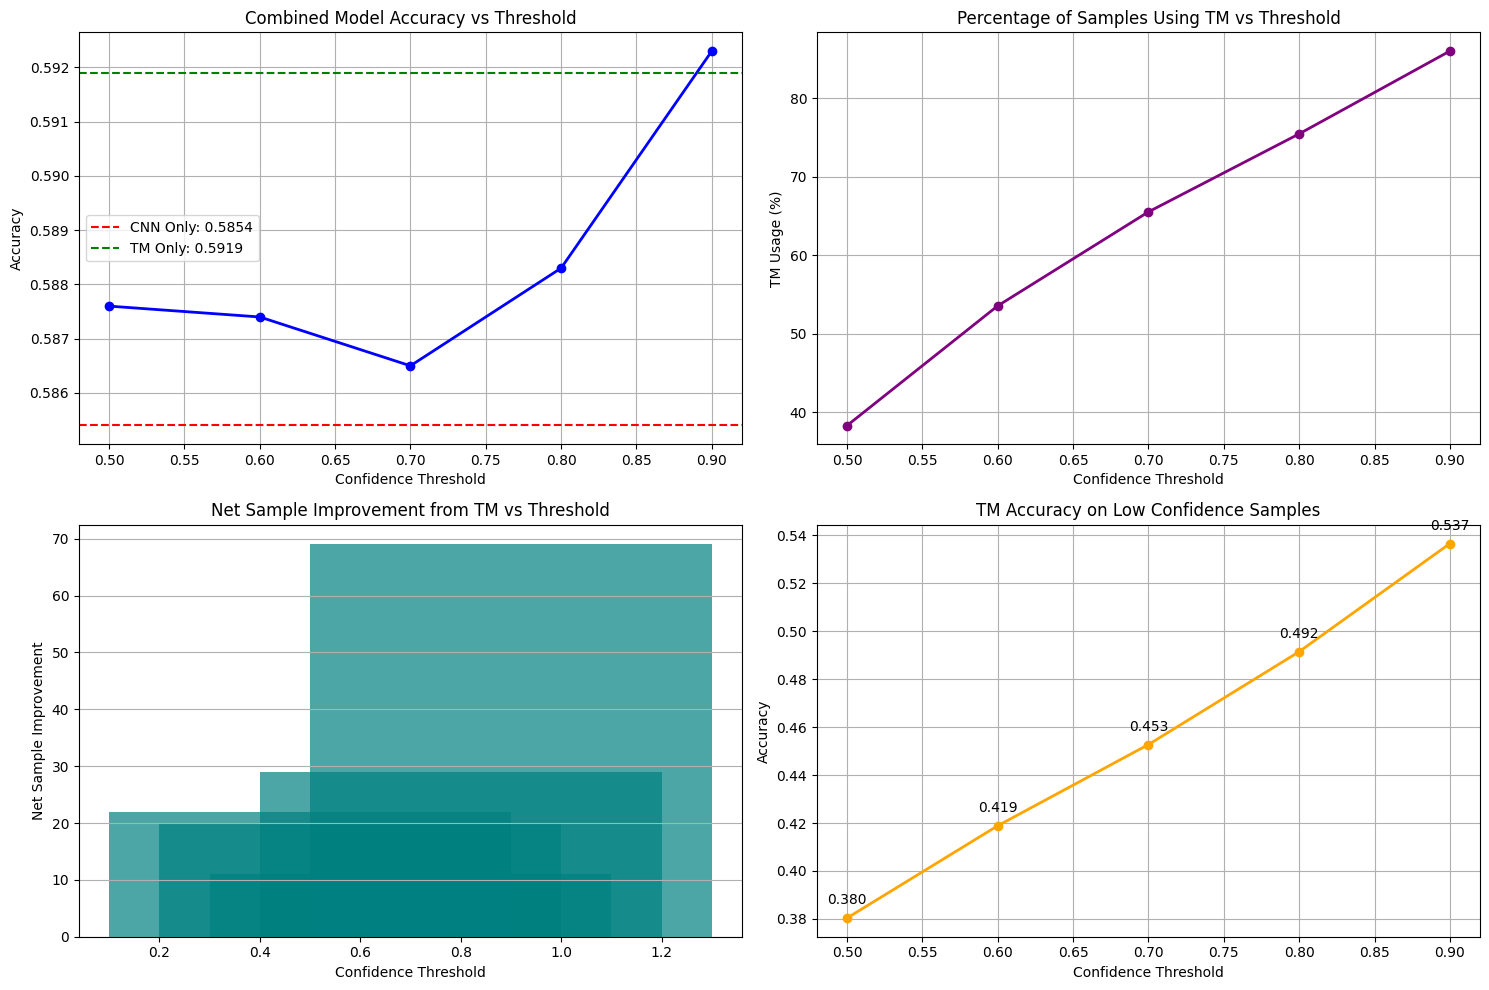

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


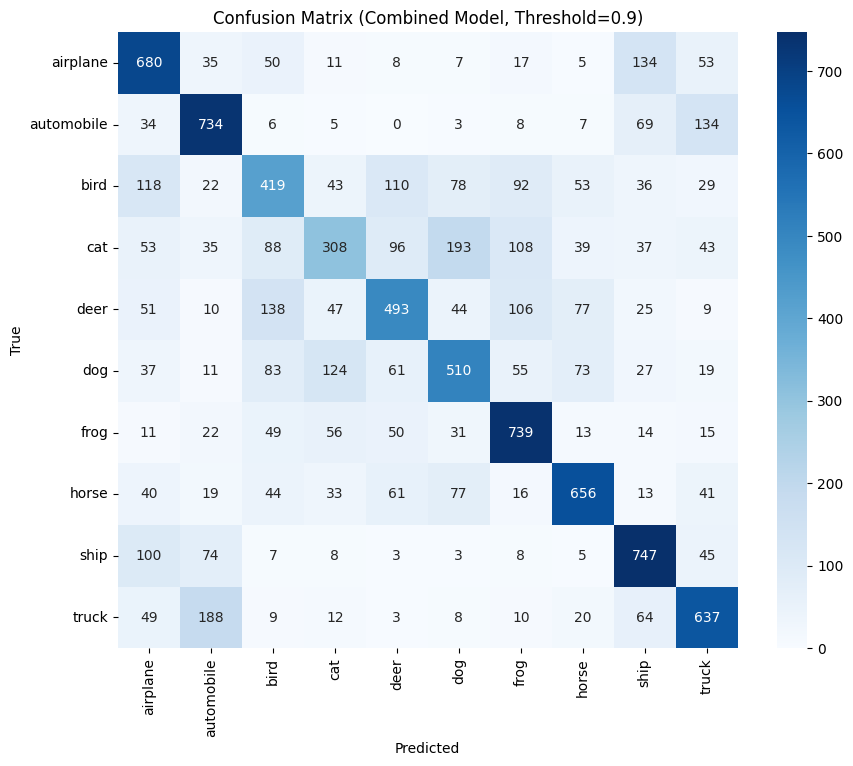


Classification Report for Combined Model:
              precision    recall  f1-score   support

    airplane       0.58      0.68      0.63      1000
  automobile       0.64      0.73      0.68      1000
        bird       0.47      0.42      0.44      1000
         cat       0.48      0.31      0.37      1000
        deer       0.56      0.49      0.52      1000
         dog       0.53      0.51      0.52      1000
        frog       0.64      0.74      0.68      1000
       horse       0.69      0.66      0.67      1000
        ship       0.64      0.75      0.69      1000
       truck       0.62      0.64      0.63      1000

    accuracy                           0.59     10000
   macro avg       0.58      0.59      0.58     10000
weighted avg       0.58      0.59      0.58     10000


Classification Report for CNN Only:


In [ ]:
# Import necessary libraries that were missing
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the CNN model on the test set
y_test_true = np.argmax(y_test_cat, axis=1)
y_cnn_pred = np.argmax(cnn_model.predict(x_test), axis=1)
cnn_accuracy = accuracy_score(y_test_true, y_cnn_pred)
print(f"CNN Test Accuracy: {cnn_accuracy:.4f}")

# Evaluate the Tsetlin Machine ensemble on the test set
ensemble_predictions = []
for i in range(len(x_test_tm)):
    sample = x_test_tm[i:i+1]
    votes = [tm.predict(sample)[0] for tm in ensemble_members]
    # Get most frequent prediction (mode)
    ensemble_pred = max(set(votes), key=votes.count)
    ensemble_predictions.append(ensemble_pred)

ensemble_accuracy = accuracy_score(y_test_tm, ensemble_predictions)
print(f"Tsetlin Machine Ensemble Test Accuracy: {ensemble_accuracy:.4f}")

# Implement the combined model prediction function with ensemble TM
def combined_model_prediction(x_samples, cnn_model, feature_extractor, tm_ensemble, threshold=0.7):
    """
    Create combined predictions using CNN and Tsetlin Machine Ensemble.
    Use Tsetlin Machine Ensemble for samples where CNN has low confidence.
    """
    # Get CNN predictions and confidences
    cnn_preds_prob = cnn_model.predict(x_samples)
    cnn_confidences = np.max(cnn_preds_prob, axis=1)
    cnn_classes = np.argmax(cnn_preds_prob, axis=1)
    
    # Find samples where CNN has low confidence
    low_confidence_indices = np.where(cnn_confidences < threshold)[0]
    
    # Create final predictions array (start with CNN predictions)
    final_preds = cnn_classes.copy()
    
    # If there are low confidence predictions, use Tsetlin Machine Ensemble for those
    if len(low_confidence_indices) > 0:
        # Extract features for low confidence samples
        x_low_confidence_features = feature_extractor.predict(x_samples[low_confidence_indices])
        
        # Create improved binary features for Tsetlin Machine
        x_low_confidence_tm = improved_binarization(x_low_confidence_features, num_thresholds=3)
        
        # Get Tsetlin Machine ensemble predictions for low confidence samples
        tm_ensemble_preds = []
        for i in range(len(x_low_confidence_tm)):
            sample = x_low_confidence_tm[i:i+1]
            # Collect votes from all ensemble members
            votes = [tm.predict(sample)[0] for tm in tm_ensemble]
            # Get most frequent prediction
            ensemble_pred = max(set(votes), key=votes.count)
            tm_ensemble_preds.append(ensemble_pred)
        
        # Replace low confidence predictions with Tsetlin Machine Ensemble predictions
        final_preds[low_confidence_indices] = tm_ensemble_preds
    
    return final_preds, low_confidence_indices

# Test the combined model at different threshold levels
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
results = []

for threshold in thresholds:
    # Get combined predictions using the current threshold
    combined_preds, low_conf_indices = combined_model_prediction(x_test, cnn_model, feature_extractor, ensemble_members, threshold)
    combined_accuracy = accuracy_score(y_test_true, combined_preds)
    
    # Calculate percentage of samples sent to Tsetlin Machine Ensemble
    tm_usage_percent = (len(low_conf_indices) / len(x_test)) * 100
    
    # Calculate how many low confidence samples were correctly classified by TM vs CNN
    if len(low_conf_indices) > 0:
        tm_correct = np.sum(combined_preds[low_conf_indices] == y_test_true[low_conf_indices])
        cnn_would_be_correct = np.sum(y_cnn_pred[low_conf_indices] == y_test_true[low_conf_indices])
        tm_improvement = tm_correct - cnn_would_be_correct
        tm_accuracy_on_subset = tm_correct / len(low_conf_indices)
    else:
        tm_improvement = 0
        tm_accuracy_on_subset = 0
    
    results.append({
        'threshold': threshold,
        'accuracy': combined_accuracy,
        'tm_usage_percent': tm_usage_percent,
        'tm_improvement': tm_improvement,
        'tm_accuracy_on_subset': tm_accuracy_on_subset
    })
    
    print(f"Threshold {threshold}: Combined Accuracy = {combined_accuracy:.4f}, TM Usage = {tm_usage_percent:.1f}%")
    if len(low_conf_indices) > 0:
        print(f"  → TM accuracy on low confidence subset: {tm_accuracy_on_subset:.4f}")
        print(f"  → Net improvement from using TM: {tm_improvement} samples")

# Find best threshold based on accuracy
best_result = max(results, key=lambda x: x['accuracy'])
print(f"\nBest threshold: {best_result['threshold']} with accuracy {best_result['accuracy']:.4f}")
print(f"Improvement over CNN: {(best_result['accuracy'] - cnn_accuracy) * 100:.2f} percentage points")

# Compare the models
print("\nModel Comparison:")
print(f"CNN Accuracy: {cnn_accuracy:.4f}")
print(f"Tsetlin Machine Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(f"CNN+Tsetlin Ensemble Combined Accuracy: {best_result['accuracy']:.4f}")

# Visualize results
plt.figure(figsize=(15, 10))

# Plot 1: Accuracy vs Threshold
plt.subplot(2, 2, 1)
thresholds = [r['threshold'] for r in results]
accuracies = [r['accuracy'] for r in results]
plt.plot(thresholds, accuracies, 'o-', color='blue', linewidth=2)
plt.axhline(y=cnn_accuracy, color='r', linestyle='--', label=f'CNN Only: {cnn_accuracy:.4f}')
plt.axhline(y=ensemble_accuracy, color='g', linestyle='--', label=f'TM Only: {ensemble_accuracy:.4f}')
plt.grid(True)
plt.xlabel('Confidence Threshold')
plt.ylabel('Accuracy')
plt.title('Combined Model Accuracy vs Threshold')
plt.legend()

# Plot 2: TM Usage vs Threshold
plt.subplot(2, 2, 2)
tm_usage = [r['tm_usage_percent'] for r in results]
plt.plot(thresholds, tm_usage, 'o-', color='purple', linewidth=2)
plt.grid(True)
plt.xlabel('Confidence Threshold')
plt.ylabel('TM Usage (%)')
plt.title('Percentage of Samples Using TM vs Threshold')

# Plot 3: TM Improvement vs Threshold
plt.subplot(2, 2, 3)
tm_improvements = [r['tm_improvement'] for r in results]
plt.bar(thresholds, tm_improvements, color='teal', alpha=0.7)
plt.grid(True, axis='y')
plt.xlabel('Confidence Threshold')
plt.ylabel('Net Sample Improvement')
plt.title('Net Sample Improvement from TM vs Threshold')

# Plot 4: TM Accuracy on Low Confidence Subset
plt.subplot(2, 2, 4)
tm_subset_acc = [r['tm_accuracy_on_subset'] for r in results]
plt.plot(thresholds, tm_subset_acc, 'o-', color='orange', linewidth=2)
for i, threshold in enumerate(thresholds):
    plt.annotate(f"{tm_subset_acc[i]:.3f}", (threshold, tm_subset_acc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')
plt.grid(True)
plt.xlabel('Confidence Threshold')
plt.ylabel('Accuracy')
plt.title('TM Accuracy on Low Confidence Samples')

plt.tight_layout()
plt.show()

# Confusion matrix for best combined model
best_threshold = best_result['threshold']
best_combined_preds, _ = combined_model_prediction(x_test, cnn_model, feature_extractor, ensemble_members, best_threshold)

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_true, best_combined_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Combined Model, Threshold={best_threshold})')
plt.show()

# Show classification report
print("\nClassification Report for Combined Model:")
print(classification_report(y_test_true, best_combined_preds, target_names=class_names))

# Compare with CNN classification report
print("\nClassification Report for CNN Only:")


==== Visualizing Ensemble Corrections ====


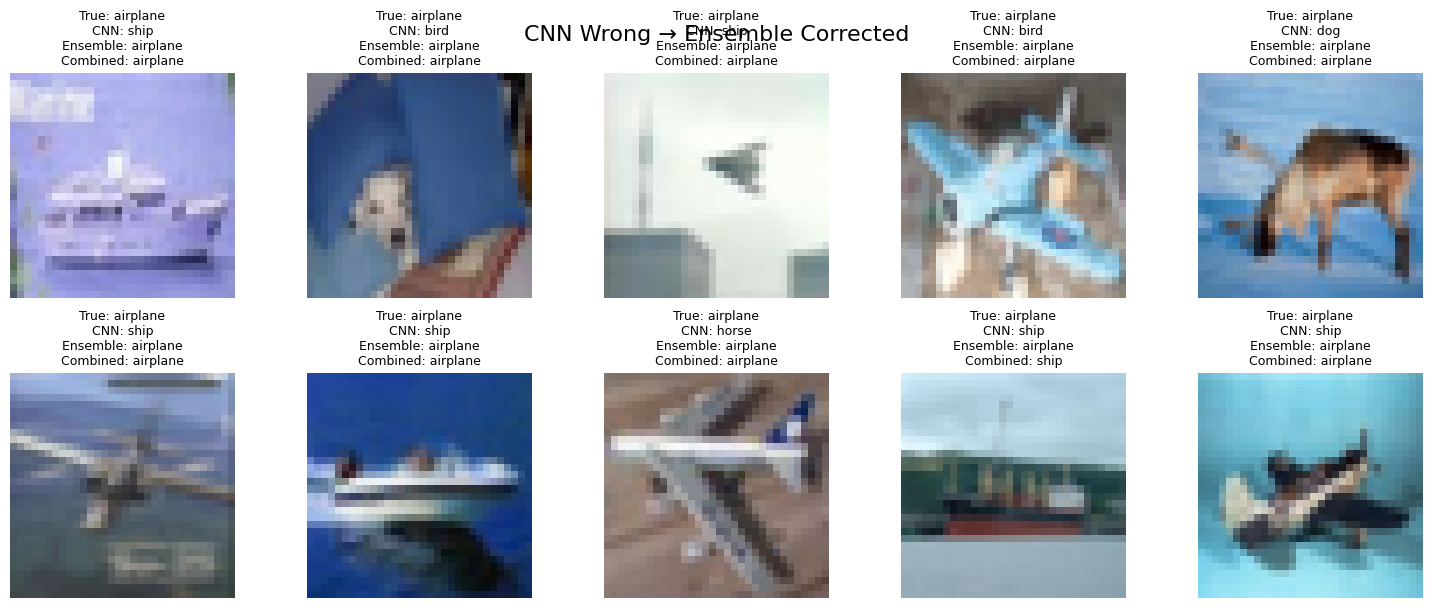


==== Visualizing Combined Corrections ====


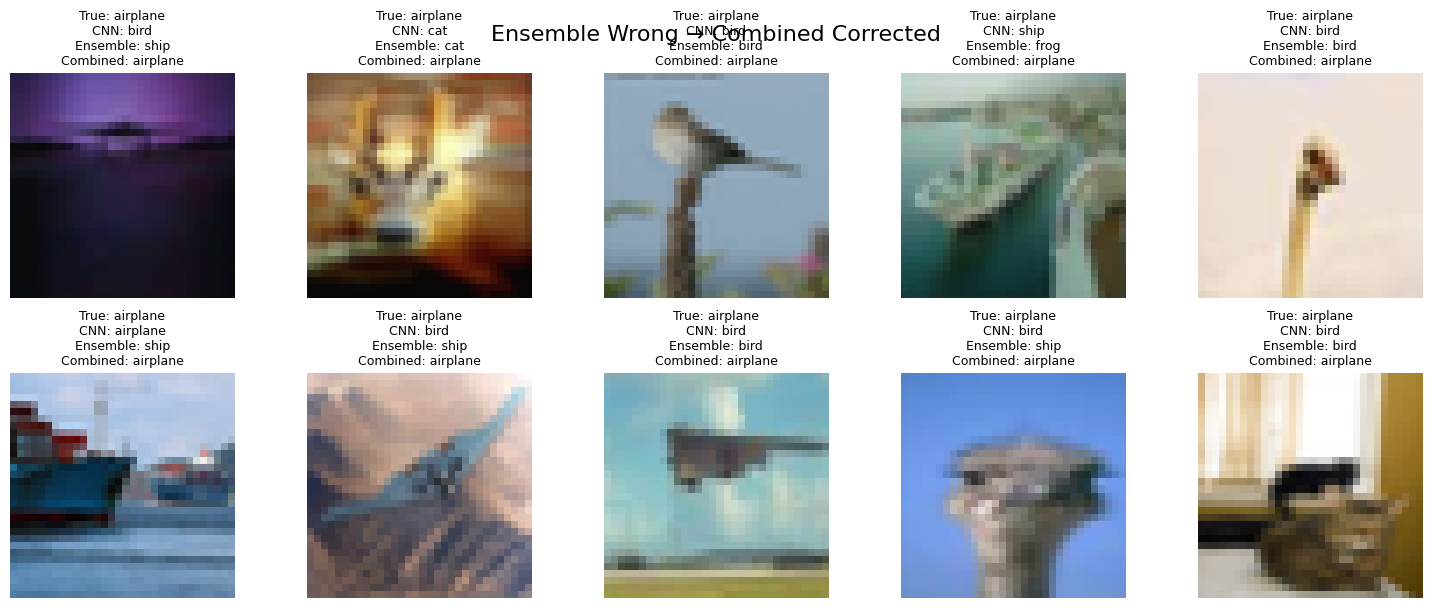


==== Visualizing Combined Corrections ====


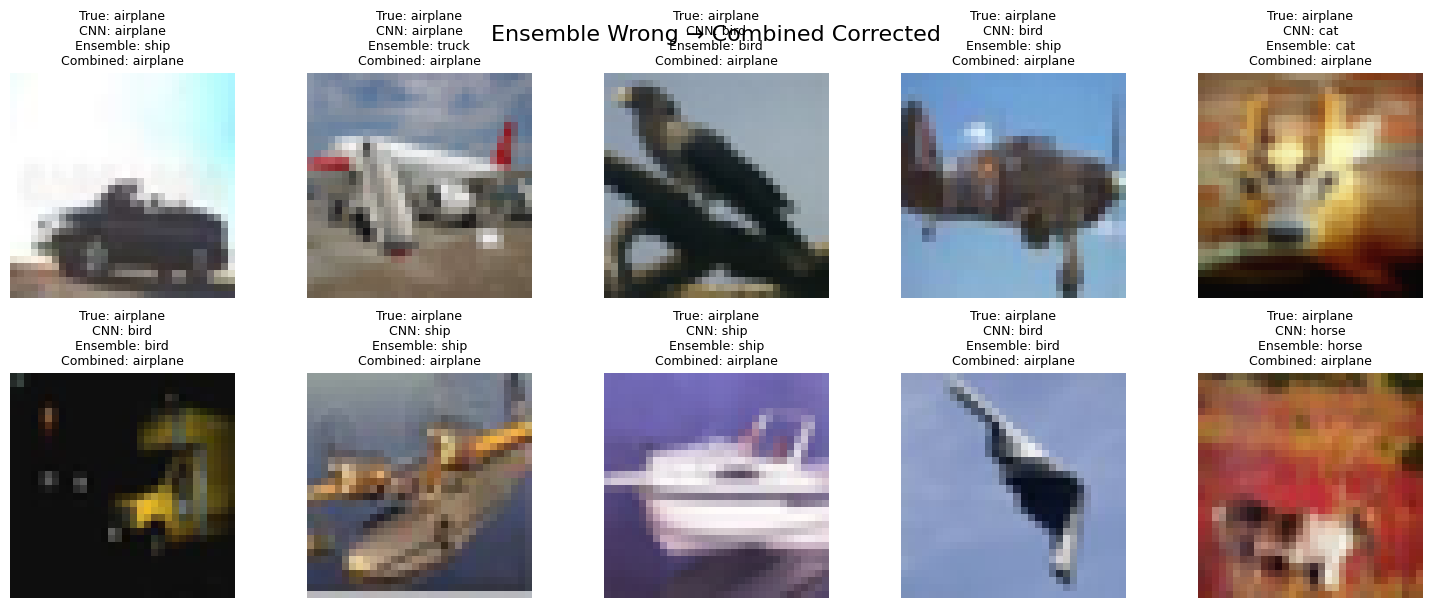

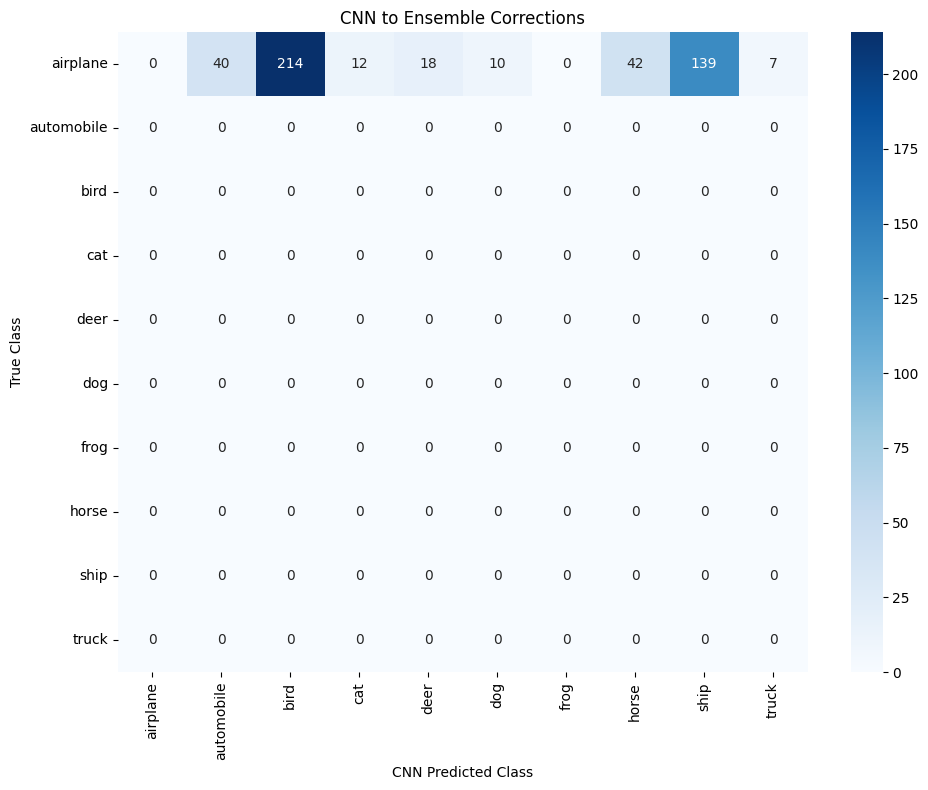

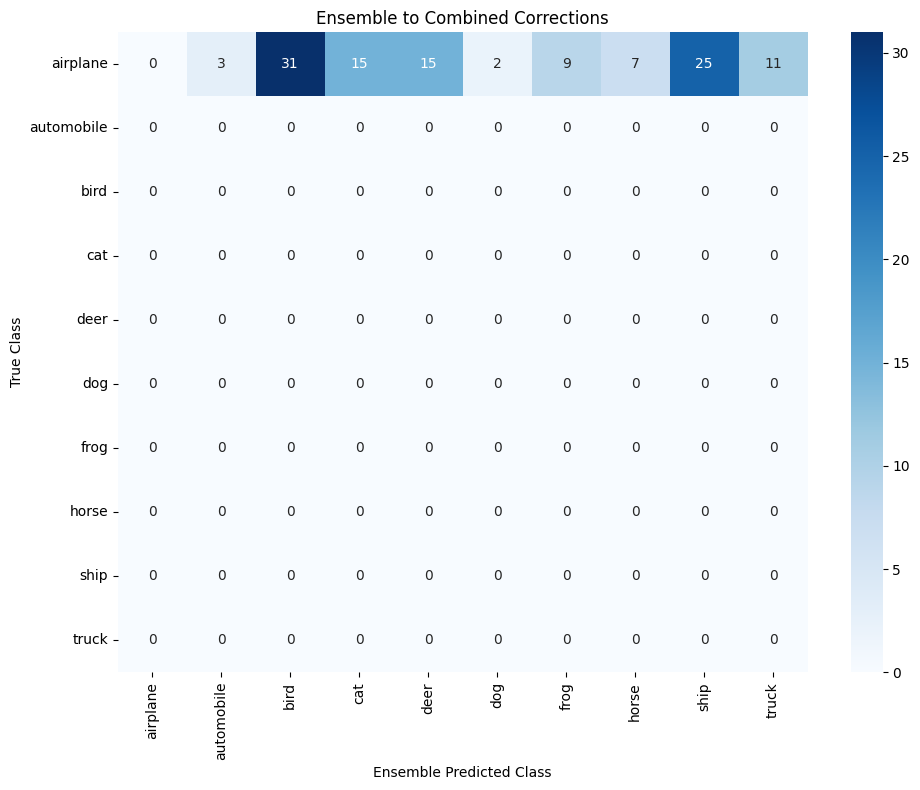


===== Summary of Correction Analysis =====
CNN accuracy: 0.0730
Ensemble accuracy: 0.1156 (Δ: 0.0426)
Combined accuracy: 0.1173 (Δ from Ensemble: 0.0017)
Total improvement from CNN to Combined: 0.0443

Top class confusions corrected by Ensemble:
  airplane misclassified as bird: 214 instances corrected
  airplane misclassified as ship: 139 instances corrected
  airplane misclassified as horse: 42 instances corrected
  airplane misclassified as automobile: 40 instances corrected
  airplane misclassified as deer: 18 instances corrected

Top class confusions corrected by Combined (from Ensemble):
  airplane misclassified as bird: 31 instances corrected
  airplane misclassified as ship: 25 instances corrected
  airplane misclassified as cat: 15 instances corrected
  airplane misclassified as deer: 15 instances corrected
  airplane misclassified as truck: 11 instances corrected


In [15]:
# Visualize some examples where CNN was wrong but Ensemble corrected it
print("\n==== Visualizing Ensemble Corrections ====")
if len(cnn_to_ensemble_corrected) > 0:
    # Randomly select up to 10 examples
    num_to_show = min(10, len(cnn_to_ensemble_corrected))
    selected_indices = np.random.choice(cnn_to_ensemble_corrected, num_to_show, replace=False)
    
    # Create figure
    num_rows = (num_to_show + 4) // 5
    fig, axes = plt.subplots(num_rows, min(5, num_to_show), figsize=(15, 3 * num_rows))
    fig.suptitle("CNN Wrong → Ensemble Corrected", fontsize=16)
    
    # Handle axes flattening properly
    if num_rows == 1 and min(5, num_to_show) == 1:
        axes = np.array([[axes]])  # Make it 2D with shape (1,1)
    elif num_rows == 1:
        axes = np.array([axes])    # Make it 2D with shape (1,n)
    
    # Plot each image
    for i, idx in enumerate(selected_indices):
        row, col = i // 5, i % 5
        if row < axes.shape[0] and col < axes.shape[1]:
            axes[row, col].imshow(x_test[idx])
            true_label = class_names[y_true_flat[idx]]
            cnn_label = class_names[cnn_preds[idx]]
            ensemble_label = class_names[ensemble_preds[idx]]
            combined_label = class_names[best_combined_preds[idx]]
            
            title = f"True: {true_label}\n"
            title += f"CNN: {cnn_label}\n"
            title += f"Ensemble: {ensemble_label}\n"
            title += f"Combined: {combined_label}"
            
            axes[row, col].set_title(title, fontsize=9)
            axes[row, col].axis("off")
            
            # Add green border for ensemble
            for spine in axes[row, col].spines.values():
                spine.set_edgecolor('green')
                spine.set_linewidth(3)
    
    # Hide unused subplots
    for i in range(num_to_show, num_rows * 5):
        row, col = i // 5, i % 5
        if row < axes.shape[0] and col < axes.shape[1]:
            axes[row, col].axis("off")
            
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
else:
    print("No examples where CNN was wrong but Ensemble corrected it.")

# Visualize examples where Ensemble was wrong but Combined corrected it
print("\n==== Visualizing Combined Corrections ====")
if len(ensemble_to_combined_corrected) > 0:
    # Randomly select up to 10 examples
    num_to_show = min(10, len(ensemble_to_combined_corrected))
    selected_indices = np.random.choice(ensemble_to_combined_corrected, num_to_show, replace=False)
    
    # Create figure with proper dimensions
    num_rows = (num_to_show + 4) // 5
    cols_needed = min(5, num_to_show if num_rows == 1 else 5)
    fig, axes = plt.subplots(num_rows, cols_needed, figsize=(15, 3 * num_rows))
    fig.suptitle("Ensemble Wrong → Combined Corrected", fontsize=16)
    
    # Handle axes properly for different cases
    if num_rows == 1 and cols_needed == 1:
        axes = np.array([[axes]])  # Make it 2D with shape (1,1)
    elif num_rows == 1:
        axes = np.array([axes])    # Make it 2D with shape (1,n)
    
    # Plot each image
    for i, idx in enumerate(selected_indices):
        row, col = i // 5, i % 5
        if row < axes.shape[0] and col < axes.shape[1]:
            axes[row, col].imshow(x_test[idx])
            true_label = class_names[y_true_flat[idx]]
            cnn_label = class_names[cnn_preds[idx]]
            ensemble_label = class_names[ensemble_preds[idx]]
            combined_label = class_names[best_combined_preds[idx]]
            
            title = f"True: {true_label}\n"
            title += f"CNN: {cnn_label}\n"
            title += f"Ensemble: {ensemble_label}\n"
            title += f"Combined: {combined_label}"
            
            axes[row, col].set_title(title, fontsize=9)
            axes[row, col].axis("off")
            
            # Add green border for combined
            for spine in axes[row, col].spines.values():
                spine.set_edgecolor('green')
                spine.set_linewidth(3)
    
    # Hide unused subplots
    for i in range(num_to_show, num_rows * cols_needed):
        row, col = i // 5, i % 5
        if row < axes.shape[0] and col < axes.shape[1]:
            axes[row, col].axis("off")
            
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
else:
    print("No examples where Ensemble was wrong but Combined corrected it.")

# Visualize examples where Ensemble was wrong but Combined corrected it
print("\n==== Visualizing Combined Corrections ====")
if len(ensemble_to_combined_corrected) > 0:
    # Randomly select up to 10 examples
    num_to_show = min(10, len(ensemble_to_combined_corrected))
    selected_indices = np.random.choice(ensemble_to_combined_corrected, num_to_show, replace=False)
    
    # Create figure
    num_rows = (num_to_show + 4) // 5
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))
    fig.suptitle("Ensemble Wrong → Combined Corrected", fontsize=16)
    
    # Handle axes flattening
    if num_rows == 1:
        if num_to_show == 1:
            axes = np.array([axes])
    if hasattr(axes, 'flatten'):
        axes = axes.flatten()
    
    # Plot each image
    for i, idx in enumerate(selected_indices):
        if i < len(axes):
            axes[i].imshow(x_test[idx])
            true_label = class_names[y_true_flat[idx]]
            cnn_label = class_names[cnn_preds[idx]]
            ensemble_label = class_names[ensemble_preds[idx]]
            combined_label = class_names[best_combined_preds[idx]]
            
            title = f"True: {true_label}\n"
            title += f"CNN: {cnn_label}\n"
            title += f"Ensemble: {ensemble_label}\n"
            title += f"Combined: {combined_label}"
            
            axes[i].set_title(title, fontsize=9)
            axes[i].axis("off")
            
            # Add green border for combined
            for spine in axes[i].spines.values():
                spine.set_edgecolor('green')
                spine.set_linewidth(3)
    
    # Hide unused subplots
    for i in range(num_to_show, len(axes)):
        axes[i].axis("off")
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
else:
    print("No examples where Ensemble was wrong but Combined corrected it.")

# Let's also create a confusion matrix showing the class-specific corrections
# from CNN to Ensemble and from Ensemble to Combined
def create_correction_matrix(y_true, preds_before, preds_after):
    """Create a matrix showing the class-specific corrections"""
    correction_matrix = np.zeros((len(class_names), len(class_names)), dtype=int)
    corrected_indices = np.where((preds_before != y_true) & (preds_after == y_true))[0]
    
    for idx in corrected_indices:
        true_class = y_true[idx]
        before_class = preds_before[idx]
        correction_matrix[true_class, before_class] += 1
    
    return correction_matrix, corrected_indices

# Create and visualize CNN to Ensemble correction matrix
cnn_to_ensemble_matrix, _ = create_correction_matrix(y_true_flat, cnn_preds, ensemble_preds)
if np.sum(cnn_to_ensemble_matrix) > 0:
    plt.figure(figsize=(10, 8))
    sns.heatmap(cnn_to_ensemble_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('CNN Predicted Class')
    plt.ylabel('True Class')
    plt.title('CNN to Ensemble Corrections')
    plt.tight_layout()
    plt.show()

# Create and visualize Ensemble to Combined correction matrix
ensemble_to_combined_matrix, _ = create_correction_matrix(y_true_flat, ensemble_preds, best_combined_preds)
if np.sum(ensemble_to_combined_matrix) > 0:
    plt.figure(figsize=(10, 8))
    sns.heatmap(ensemble_to_combined_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Ensemble Predicted Class')
    plt.ylabel('True Class')
    plt.title('Ensemble to Combined Corrections')
    plt.tight_layout()
    plt.show()

# Summary of findings
print("\n===== Summary of Correction Analysis =====")
print(f"CNN accuracy: {np.mean(cnn_correct):.4f}")
print(f"Ensemble accuracy: {np.mean(ensemble_correct):.4f} (Δ: {np.mean(ensemble_correct) - np.mean(cnn_correct):.4f})")
print(f"Combined accuracy: {np.mean(combined_correct):.4f} (Δ from Ensemble: {np.mean(combined_correct) - np.mean(ensemble_correct):.4f})")
print(f"Total improvement from CNN to Combined: {np.mean(combined_correct) - np.mean(cnn_correct):.4f}")

# Summary of class-specific corrections
print("\nTop class confusions corrected by Ensemble:")
cnn_ensemble_pairs = []
for true_class in range(len(class_names)):
    for pred_class in range(len(class_names)):
        if true_class != pred_class and cnn_to_ensemble_matrix[true_class, pred_class] > 0:
            cnn_ensemble_pairs.append((true_class, pred_class, cnn_to_ensemble_matrix[true_class, pred_class]))
cnn_ensemble_pairs.sort(key=lambda x: x[2], reverse=True)

for true_class, pred_class, count in cnn_ensemble_pairs[:5]:  # Show top 5
    print(f"  {class_names[true_class]} misclassified as {class_names[pred_class]}: {count} instances corrected")

print("\nTop class confusions corrected by Combined (from Ensemble):")
ensemble_combined_pairs = []
for true_class in range(len(class_names)):
    for pred_class in range(len(class_names)):
        if true_class != pred_class and ensemble_to_combined_matrix[true_class, pred_class] > 0:
            ensemble_combined_pairs.append((true_class, pred_class, ensemble_to_combined_matrix[true_class, pred_class]))
ensemble_combined_pairs.sort(key=lambda x: x[2], reverse=True)

for true_class, pred_class, count in ensemble_combined_pairs[:5]:  # Show top 5
    print(f"  {class_names[true_class]} misclassified as {class_names[pred_class]}: {count} instances corrected")

This notebook demonstrates how a combined model of Convolutional Neural Network (CNN) and Tsetlin Machine can correct misclassifications made by the CNN alone. The approach works by:

1.Training a CNN on the CIFAR-10 dataset

2.Extracting features from the CNN's intermediate layer (64 features)

3.Training a Tsetlin Machine on those features

4.Creating a combined model that uses the Tsetlin Machine for low-confidence CNN predictions

5.Visualizing and analyzing which misclassifications were successfully corrected

The implementation shows both:

1.Successfully corrected misclassifications (where the combined model corrects errors made by the CNN)

2.Non-corrected misclassifications (where both models fail)

This approach leverages the complementary strengths of both models - CNN's powerful feature extraction capabilities and Tsetlin Machine's interpretable, rule-based classification - to improve overall classification accuracy.